In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
data_dir = 'raw-img' #Animals-10 dataset

In [3]:
ds = tf.keras.utils.image_dataset_from_directory( #data loading
    data_dir,
    labels = 'inferred',
    label_mode = 'int',
    color_mode = 'rgb',
    image_size = (128,128),
    shuffle = True,
    seed = 42,
    interpolation="bilinear"
)

Found 26179 files belonging to 10 classes.


In [4]:
class_names = ds.class_names

In [5]:
class_names

['butterfly',
 'cat',
 'cow',
 'dog',
 'elephant',
 'hen',
 'horse',
 'sheep',
 'spider',
 'squirrel']

In [6]:
def preprocess(img, label):                 #data normalization
    img = tf.cast(img, 'float32') / 255.0
    return img,label

ds = ds.map(lambda img, label: preprocess(img, label))

In [7]:
def plot_history(history):
    plt.figure(figsize = (8,6))
    plt.plot(history.history['loss'], 'r', linewidth=3.0)            #plotter visualization
    plt.plot(history.history['val_loss'], 'b', linewidth=3.0)
    plt.legend(['loss', 'val_loss'], fontsize=18)
    plt.xlabel('Epochs',fontsize=16)
    plt.ylabel('Loss',fontsize=16)
    plt.title('Learning Curve', fontsize=16)

    plt.figure(figsize = (8,6))
    plt.plot(history.history['accuracy'], 'r', linewidth=3.0)
    plt.plot(history.history['val_accuracy'], 'b', linewidth=3.0)
    plt.legend(['accuracy', 'val_accuracy'],fontsize=18)
    plt.xlabel('Epochs',fontsize=16)
    plt.ylabel('Loss',fontsize=16)
    plt.title('Accuracy', fontsize=16)

In [8]:
def int_to_class(label):
    return class_names[label]

In [9]:
images = []
labels = []

for image, label in ds.unbatch():
    images.append(image.numpy())  
    labels.append(label.numpy())

images = np.array(images)
labels = np.array(labels)  #convert to numpy array


train_images, val_images, train_labels, val_labels = train_test_split(   #split dataset to train and test
    images, labels, test_size=0.2, stratify=labels, random_state=42
)

In [10]:
unique_classes, counts = np.unique(train_labels, return_counts=True)
class_counts = dict(zip(unique_classes, counts))

class_counts_names = {int_to_class(k): v for k, v in class_counts.items()}
pd.DataFrame.from_dict(class_counts_names, orient='index').T

,butterfly,cat,cow,dog,elephant,hen,horse,sheep,spider,squirrel
0,1690,1334,1493,3890,1157,2478,2098,1456,3857,1490


In [11]:
def plot_cm(test_images,test_labels,model): #visualization confusion matrix
    y_pred = model.predict(test_images)
    y_pred = np.argmax(y_pred, axis=1)  
    cm = confusion_matrix(test_labels, y_pred)
    display = ConfusionMatrixDisplay(confusion_matrix = cm,
                                    display_labels = class_counts_names.keys())
    display.plot() 
    display.ax_.set_title("Confusion Matrix")
    display.ax_.set_xlabel("Predicted")
    display.ax_.set_ylabel("Actual")
    plt.xticks(rotation=90)
    plt.show()

In [12]:
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

In [13]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),  # Random horizontal reflection
    tf.keras.layers.RandomRotation(0.2),       #Random rotation ±20% of 360° 
    tf.keras.layers.RandomZoom(0.2),           #Random zoom (zoom in/out) up to 20%
    tf.keras.layers.RandomContrast(0.1)        #±10% contrast adjustment
])

In [14]:
inputs = tf.keras.layers.Input(shape=(128,128,3)) 

# body 
x = base_model(inputs)
x = tf.keras.layers.BatchNormalization()(x)
# head of the model
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128,activation='relu')(x)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

# create model
model = tf.keras.Model(inputs= inputs, outputs = outputs)

In [15]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_128 (Functional)    │ (None, 4, 4, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 4, 4, 1280)          │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 20480)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       2,621,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,885,962 (18.64 MB)

 Trainable params: 2,659,530 (10.15 MB)

 Non-trainable params: 2,226,432 (8.49 MB)

In [16]:
opt = tf.keras.optimizers.Adam(learning_rate = 0.0005)

In [17]:
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics = ['accuracy']) #model compilation

In [18]:
history_3 = model.fit(train_images, train_labels, validation_data=(val_images,val_labels), #model fit
                    epochs =10 ,batch_size=32)

Epoch 1/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 522s 751ms/step - accuracy: 0.8423 - loss: 0.5353 - val_accuracy: 0.9173 - val_loss: 0.2724
Epoch 2/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 455s 695ms/step - accuracy: 0.9500 - loss: 0.1584 - val_accuracy: 0.9196 - val_loss: 0.2836
Epoch 3/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 467s 714ms/step - accuracy: 0.9650 - loss: 0.1047 - val_accuracy: 0.9261 - val_loss: 0.2812
Epoch 4/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 437s 667ms/step - accuracy: 0.9758 - loss: 0.0729 - val_accuracy: 0.9269 - val_loss: 0.2982
Epoch 5/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 448s 685ms/step - accuracy: 0.9771 - loss: 0.0698 - val_accuracy: 0.9297 - val_loss: 0.3047
Epoch 6/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 456s 696ms/step - accuracy: 0.9826 - loss: 0.0545 - val_accuracy: 0.9322 - val_loss: 0.3133
Epoch 7/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 451s 688ms/step - accuracy: 0.9872 - loss: 0.0402 - val_accuracy: 0.9324 - val_loss: 0.3354
Epoch 8/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 448s 684ms/step - accuracy: 0.9864 -

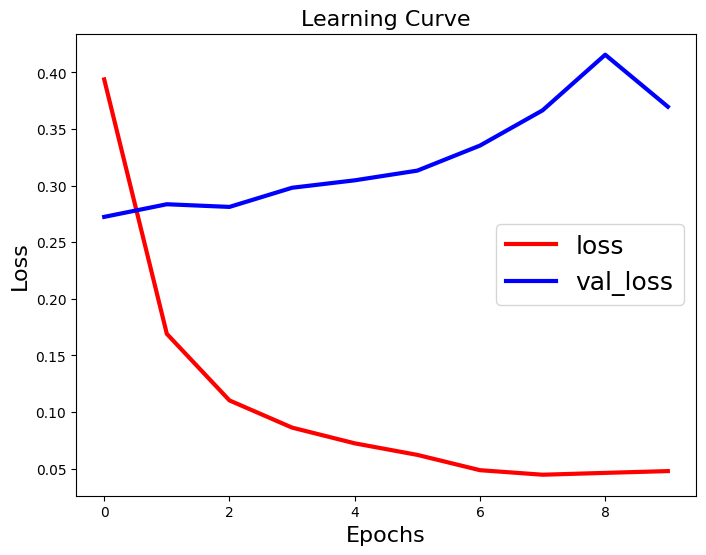

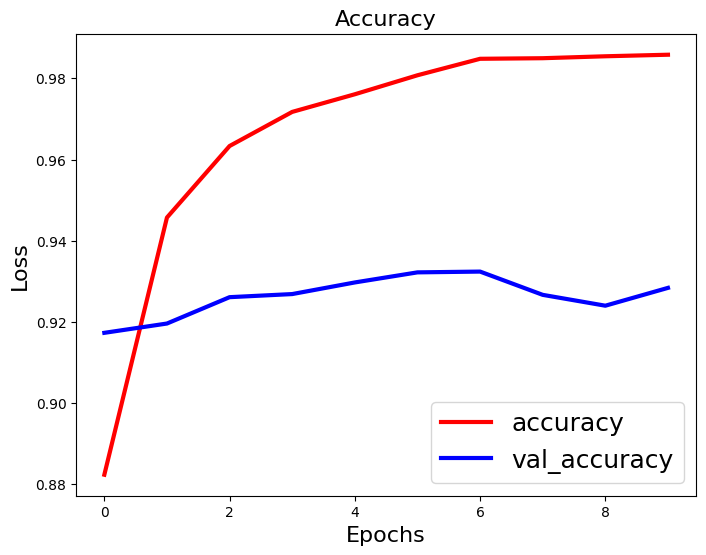

In [19]:
plot_history(history_3) 

164/164 ━━━━━━━━━━━━━━━━━━━━ 38s 223ms/step


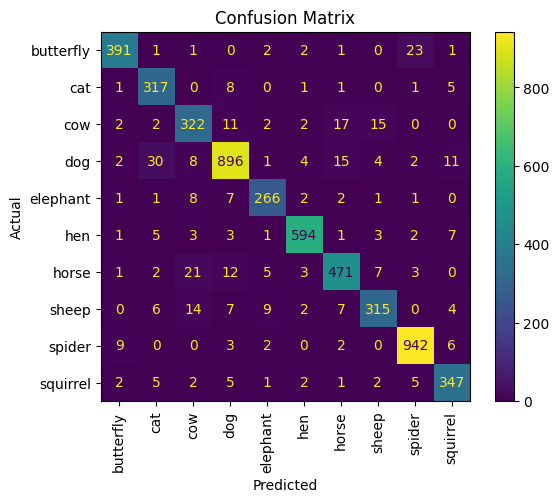

In [20]:
plot_cm(val_images,val_labels, model) #confusion Matrix

In [23]:
model.save("my_model.keras") #save model

In [24]:
loss, accuracy = model.evaluate(val_images, val_labels)
print(f"Validation accuracy: {accuracy:.4f}")

164/164 ━━━━━━━━━━━━━━━━━━━━ 34s 205ms/step - accuracy: 0.9291 - loss: 0.3597
Validation accuracy: 0.9284


In [30]:
idx = 2 
image = np.expand_dims(val_images[idx], axis=0)
pred = model.predict(image)
predicted_class = np.argmax(pred)

print(f"Predicted class: {predicted_class}, True class: {val_labels[idx]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Predicted class: 2, True class: 2


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


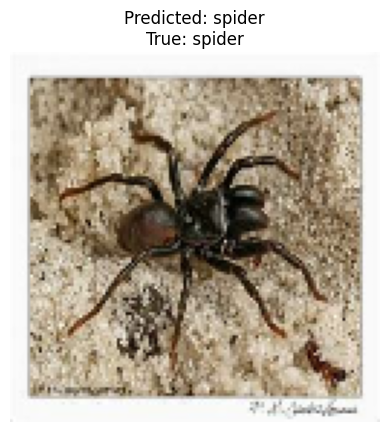

In [49]:
import numpy as np
import matplotlib.pyplot as plt

# random image from val_images
idx = np.random.randint(len(val_images))
image = np.expand_dims(val_images[idx], axis=0)  #add batch-dimension

# Делаем предсказание
pred = model.predict(image)
predicted_class = np.argmax(pred)  # Index of the class with the highest probability

# Image visualization
plt.imshow(val_images[idx]) 
plt.axis("off")
plt.title(f"Predicted: {int_to_class(predicted_class)}\nTrue: {int_to_class(val_labels[idx])}")
plt.show()


In [20]:
opt = tf.keras.optimizers.Adam(learning_rate = 0.0005)


In [21]:
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics = ['accuracy']) #model compilation

In [23]:
history_res = model.fit(images, labels,  #model fit
                    epochs =6 ,batch_size=32)

Epoch 1/6
819/819 ━━━━━━━━━━━━━━━━━━━━ 618s 720ms/step - accuracy: 0.8474 - loss: 0.5102 
Epoch 2/6
819/819 ━━━━━━━━━━━━━━━━━━━━ 575s 702ms/step - accuracy: 0.9489 - loss: 0.1591
Epoch 3/6
819/819 ━━━━━━━━━━━━━━━━━━━━ 564s 688ms/step - accuracy: 0.9654 - loss: 0.1088
Epoch 4/6
819/819 ━━━━━━━━━━━━━━━━━━━━ 557s 681ms/step - accuracy: 0.9759 - loss: 0.0769
Epoch 5/6
819/819 ━━━━━━━━━━━━━━━━━━━━ 544s 664ms/step - accuracy: 0.9808 - loss: 0.0582
Epoch 6/6
819/819 ━━━━━━━━━━━━━━━━━━━━ 544s 665ms/step - accuracy: 0.9810 - loss: 0.0599


In [24]:
model.save("res_model.keras") 